In [8]:
%env WORKDIR ~/Documents/weatherpy-work/

import sys
sys.path.append('..')

from wxdata import stormevents

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

env: WORKDIR=~/Documents/weatherpy-work/


In [2]:
df = stormevents.tornadoes('2011-04-25 00:00', '2011-04-29 00:00', tz='CST')

In [3]:
df.columns

Index(['begin_yearmonth', 'begin_day', 'begin_time', 'end_yearmonth',
       'end_day', 'end_time', 'episode_id', 'event_id', 'state', 'state_fips',
       'year', 'month_name', 'event_type', 'cz_type', 'cz_fips', 'cz_name',
       'wfo', 'begin_date_time', 'cz_timezone', 'end_date_time',
       'injuries_direct', 'injuries_indirect', 'deaths_direct',
       'deaths_indirect', 'damage_property', 'damage_crops', 'source',
       'magnitude', 'magnitude_type', 'flood_cause', 'category', 'tor_f_scale',
       'tor_length', 'tor_width', 'tor_other_wfo', 'tor_other_cz_state',
       'tor_other_cz_fips', 'tor_other_cz_name', 'begin_range',
       'begin_azimuth', 'begin_location', 'end_range', 'end_azimuth',
       'end_location', 'begin_lat', 'begin_lon', 'end_lat', 'end_lon',
       'episode_narrative', 'event_narrative', 'data_source'],
      dtype='object')

In [4]:
clusters = stormevents.clust.st_clusters(df, eps_km=90, eps_min=60, min_samples=30)

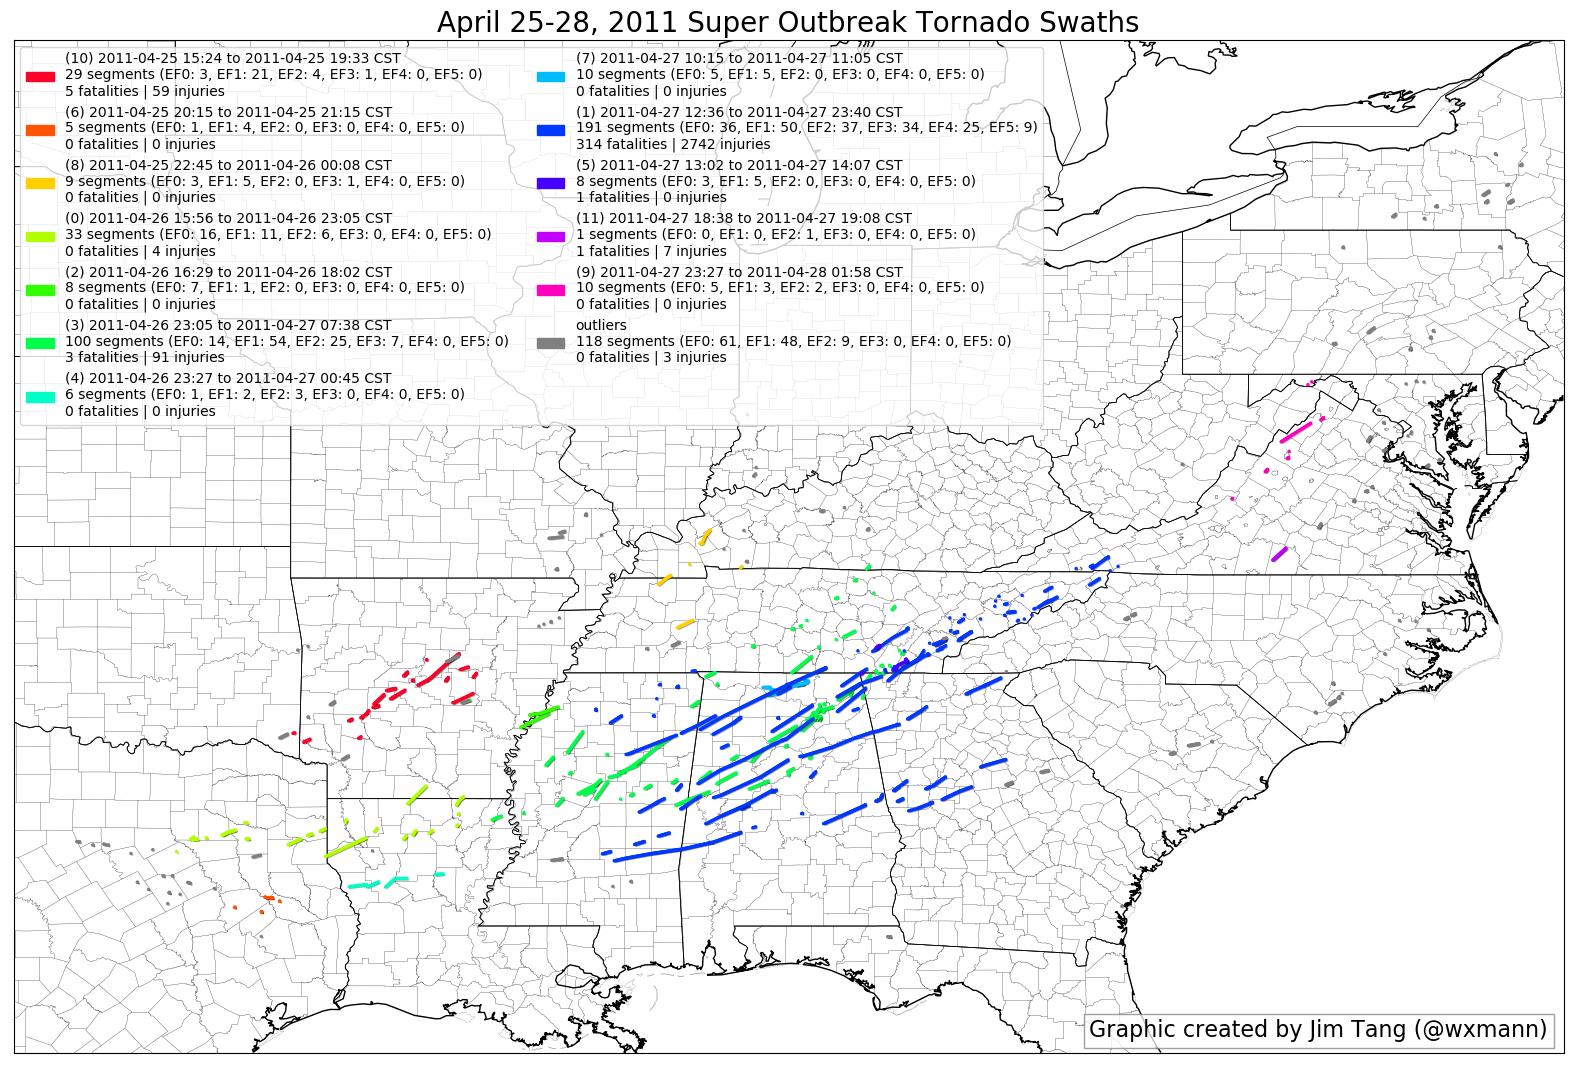

In [12]:
from mpl_toolkits.basemap import Basemap
from wxdata.utils import sample_colors
from wxdata.stormevents.clusters import plot_clusters, legend_labels

fig = plt.figure(figsize=(20, 20), dpi=100)

llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat = -99, -74.5, 29, 45
m = Basemap(projection='cyl', 
            llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat, urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat,
            resolution='i',area_thresh=1000)

m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawcounties()

colors = sample_colors(len(clusters), 'gist_rainbow')
plot_clusters(clusters, m, colors)

plt.legend(handles=legend_labels(clusters, colors), loc=2, ncol=2)
plt.title('April 25-28, 2011 Super Outbreak Tornado Swaths', fontsize=20)

ax = fig.axes[0]
plt.text(0.99, 0.01, 'Graphic created by Jim Tang (@wxmann)', transform=ax.transAxes, fontsize=16,
        verticalalignment='bottom', horizontalalignment='right', 
        bbox=dict(alpha=0.75, facecolor='white', edgecolor='gray'))
plt.show()